<a href="https://colab.research.google.com/github/TaviTragus/data-science-fundamentals/blob/main/Unit6/TaviTragU6Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####boring tings####

In [40]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import statsmodels.api as sm
import seaborn as sns
import xarray as xr
import math

from scipy.stats import bernoulli
from scipy.interpolate import PchipInterpolator
from statsmodels.miscmodels.ordinal_model import OrderedModel

#Unit 5 Project#

##The Data##

I was googling around and found this data set from UC Irvine: https://archive.ics.uci.edu/dataset/186/wine+quality. It contains a lot of measurable numeric things and a subjective ranking of the wine (on a scale of 1-10). I went through pretty much all of the combinations to see which had an interesting correlation. There were some obvious ones, like the relationships between fixed acidity, volatile acidity, citric acid, and pH seem to have correlations.

In [24]:
#importing data!
url_wine = 'https://raw.githubusercontent.com/TaviTragus/data-science-fundamentals/refs/heads/main/winequality-red.csv'
wine = pd.read_csv(url_wine,dtype={'Gc':'category'})
wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


I want to try to predict the quality of the wine with something. I think that something like alcohol, density or acidity might be good. I graphed quality with respect to different measurable things, and alcohol had a trend (extremely weak :( )

<Axes: xlabel='density', ylabel='quality'>

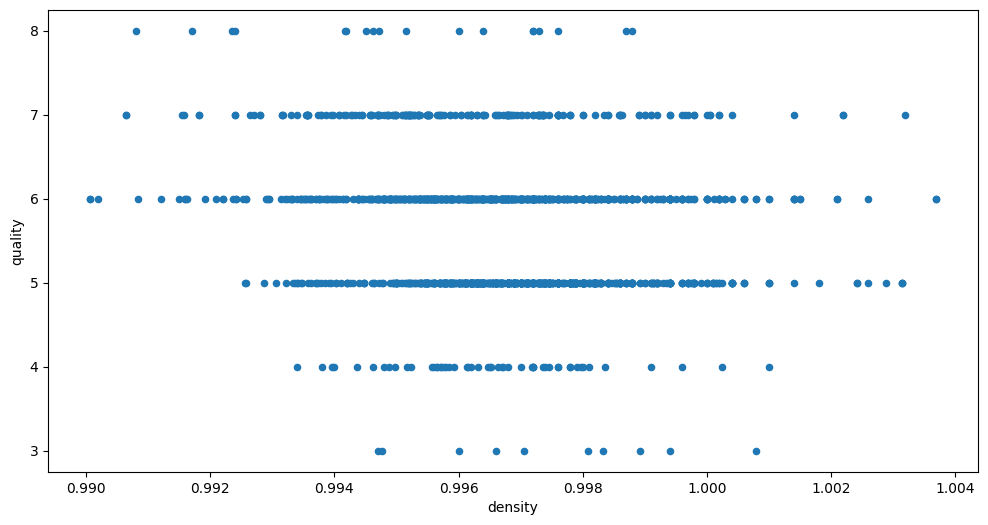

In [ ]:
wine.plot(x="density", y="quality", figsize=(12, 6), kind="scatter")

<Axes: xlabel='sulphates', ylabel='quality'>

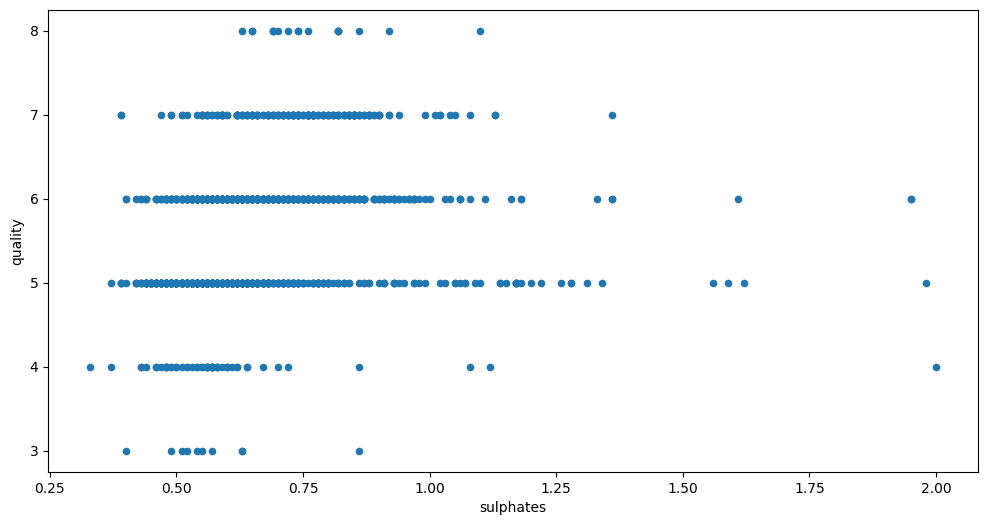

In [ ]:
wine.plot(x="sulphates", y="quality", figsize=(12, 6), kind="scatter")

<Axes: xlabel='alcohol', ylabel='quality'>

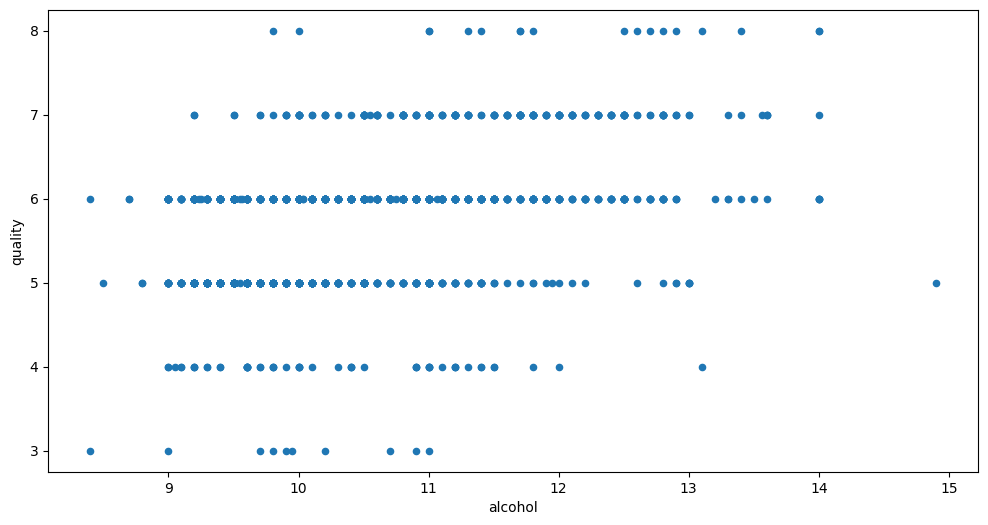

In [ ]:
wine.plot(x="alcohol", y="quality", figsize=(12, 6), kind="scatter")

I think it is really interesting that the more alcoholic a wine is, generally the higher quality it is. Maybe that has to do with like fermentation time? Like the longer something ferments the more alcohol it will contain and also the longer something ferments, the higher quality (more expensive) it is?



##The model?##

Mr. Arredondo suggested that I look into ordered categorical outcomes, because what I want to be the 'y-value' of my model is ordered and categorical. There are categories (3-8), and an 8 is better than a 7 is better than a 6, etc. I looked into this online because I hadn't heard of this before. PYMC documentation told me to use an OrderedLogistic distribution for my y. (https://www.pymc.io/projects/docs/en/latest/api/distributions/generated/pymc.OrderedLogistic.html and https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-ordinal-regression.html)

###hide###

In [ ]:
#this code is just stolen from the pymc documentation, so I can play with it here, source https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-ordinal-regression.html

#def constrainedUniform(N, group, min=0, max=1):   #I think this function makes a distribution that helps split our prior into parts, based on the number
#    return pm.Deterministic(                      #of ouput categoris
#        f"cutpoints_{group}",
#        pt.concatenate(
#            [
#                np.ones(1) * min,
#                pt.extra_ops.cumsum(pm.Dirichlet(f"cuts_unknown_{group}", a=np.ones(N - 2)))
#                * (max - min)
#                + min,
#            ]
#        ),
#    )
#
#K = 9
#movies_by_rating = movies_by_rating[movies_by_rating["movie_id"].isin([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])]
#indx, unique = pd.factorize(movies_by_rating["movie_id"])
#priors = {"sigma": 1, "mu": [0, 1], "cut_mu": np.linspace(0, K, K - 1)}
#
#def make_movies_model(ordered=False):
#    with pm.Model() as model:
#        for g in movies_by_rating["movie_id"].unique():
#            if ordered:
#                cutpoints = constrainedUniform(K, g, 0, K - 1)
#                mu = pm.Normal(f"mu_{g}", 0, 1)
#                y_ = pm.OrderedLogistic(
#                    f"y_{g}",
#                    cutpoints=cutpoints,
#                    eta=mu,
#                    observed=movies_by_rating[movies_by_rating["movie_id"] == g].rating.values,
#                )
#            else:
#                mu = pm.Normal(f"mu_{g}", 0, 1)
#                sigma = pm.HalfNormal(f"sigma_{g}", 1)
#                y_ = pm.Normal(
#                    f"y_{g}",
#                    mu,
#                    sigma,
#                    observed=movies_by_rating[movies_by_rating["movie_id"] == g].rating.values,
#                )
#
#        idata = pm.sample_prior_predictive()
#        idata.extend(pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True}))
#        idata.extend(pm.sample_posterior_predictive(idata))
#    return idata, model
#
#
#idata_ordered, model_ordered = make_movies_model(ordered=True)
#idata_normal_metric, model_normal_metric = make_movies_model(ordered=False)

###ting###

In [ ]:
K = 9

In [ ]:
def constrainedUniform(N, min=0, max=1):   #I think this function makes a distribution that helps split our prior into parts, based on the number
    return pm.Deterministic(               #of ouput categoris
        "cutpoints",
        pt.concatenate(
            [
                np.ones(1) * min,
                pt.extra_ops.cumsum(pm.Dirichlet("cuts_unknown", a=np.ones(N - 2))) * (max - min)
                + min,
            ]
        ),
    ) #source pymc documentation: https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-ordinal-regression.html

with pm.Model() as model1:
  cutpoints = constrainedUniform(K, 0, K)

  #priors
  alpha = pm.Normal('alpha', 0, 5)
  beta = pm.Normal("beta", 0, 4)

  #deterministic to make linear model
  mu = pm.Deterministic("mu", alpha + beta * wine.alcohol)

  #ordered logistic, which is good for ordered categorical outcomes (ratings)
  y_ = pm.OrderedLogistic("y", cutpoints=cutpoints, eta=mu, observed=wine.quality)

  idata1 = pm.sample()


Output()

Output()

ERROR:pymc.stats.convergence:There were 12 divergences after tuning. Increase `target_accept` or reparameterize.


The OrderedLogistic distribution takes two inputs: cutpoints and eta. Cutpoints defines how many categories there are and eta is the input for the data. My eta is the linear model, using alpha + beta * wine.alcohol. I am struggling to get this to run. It only works when cutpoints is 9, which is what I first tried (because ideally there are 10 categories). My data only has six categories, so I have tried 5 cutpoints. The highest category is 8, so I tried 7 cutpoints. Then I just started trying other numbers from 1-9. Everything below 9 got the error: SamplingError: Initial evaluation of model at starting point failed!

###hide###

Now that the model sort of runs, I have the challenge of visualising it. I am using various different methods from the documentation and the notes. First, from the documentation, I think this just estimates the likelihood that a wine will be of a certain quality.

Text(0, 0.5, 'quality')

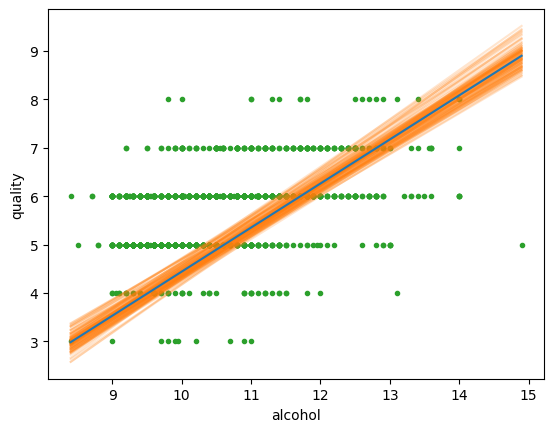

In [ ]:
#grabs 100 posterior samples
posterior = az.extract(idata1, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(wine.alcohol.min(), wine.alcohol.max(), 50),
    dims="plot_id"
    )

# this creates the expected line, the path we predict temperature and
#rented bike count deviates from
mean_line = posterior["alpha"].mean() + posterior["beta"].mean() * x_plot

#These are a 50 lines that our model came up with
lines = posterior["alpha"] + posterior["beta"] * x_plot

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(wine.alcohol, wine.quality, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("alcohol")
ax.set_ylabel("quality")

This isn't doing what I want it to, because I am taking from the mu, not my y distribution. I don't know how to take samples from the OrderedLogistic distribution, so this plot doesn't reflect much, it was just the first thing I tried.

In [ ]:
implied_probs = az.extract(idata1, var_names=["y_probs"])
implied_probs.shape

(1599, 9, 2000)

In [ ]:
implied_probs[0].mean(axis=1)

<xarray.DataArray 'y_probs' (y_probs_dim_1: 9)> Size: 72B
array([0.02084825, 0.00104023, 0.00105683, 0.0112386 , 0.05485268,
       0.5782611 , 0.28679533, 0.0400228 , 0.00588418])
Coordinates:
    y_probs_dim_0  int64 8B 0
  * y_probs_dim_1  (y_probs_dim_1) int64 72B 0 1 2 3 4 5 6 7 8

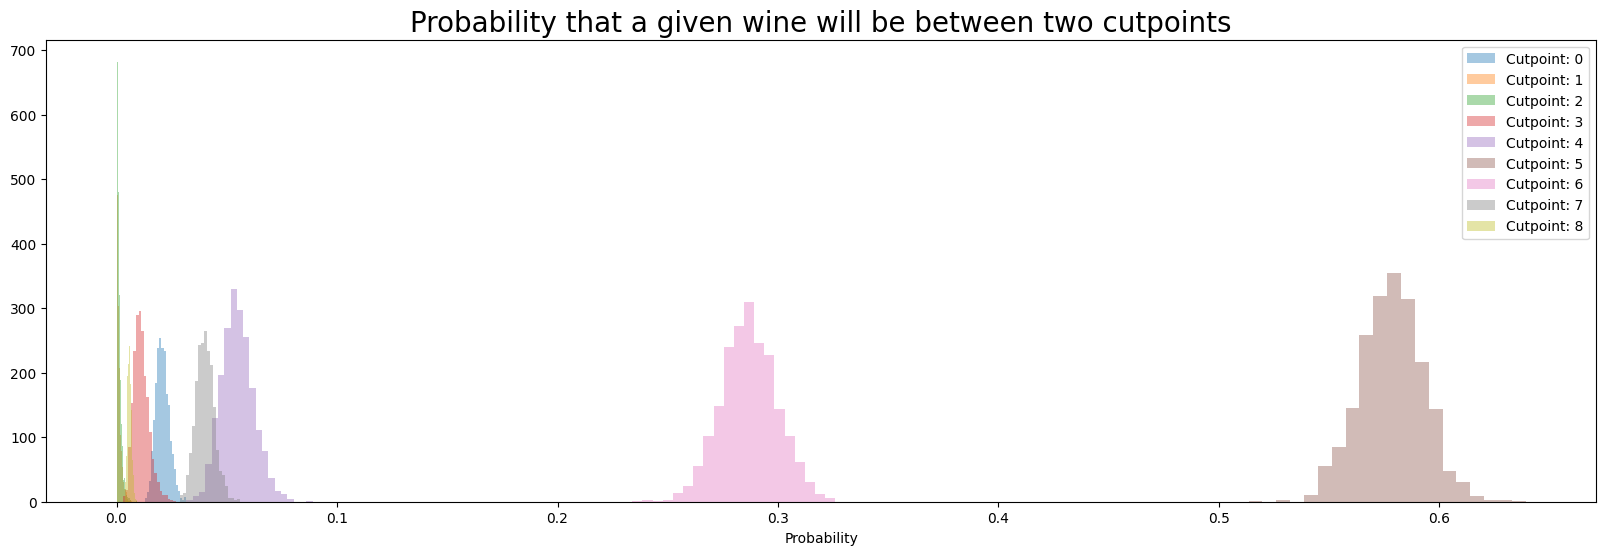

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
for i in range(K):
    ax.hist(implied_probs[0, i, :], label=f"Cutpoint: {i}", ec="white", bins=20, alpha=0.4)
ax.set_xlabel("Probability")
ax.set_title("Probability that a given wine will be between two cutpoints", fontsize=20)
ax.legend();

It isn't very well explained, but I think this is a way to check your model against your data, because you can see how the results compare to the input.

Output()

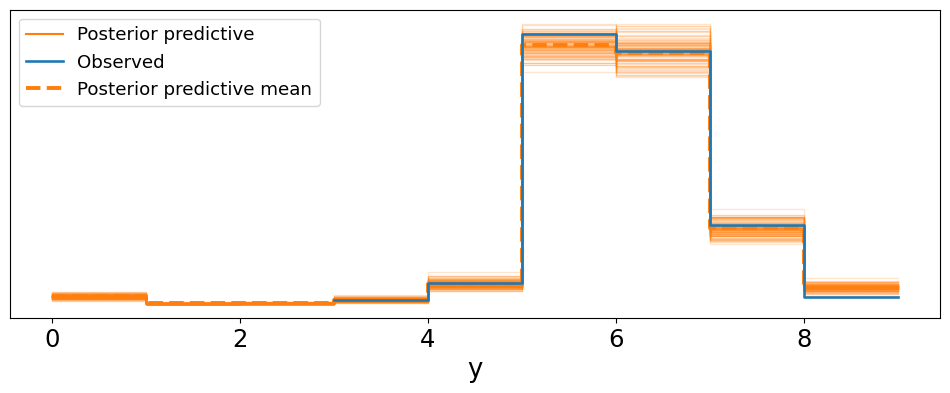

In [ ]:
pm.sample_posterior_predictive(idata1, model=model1, extend_inferencedata=True)
axL = az.plot_ppc(idata1, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

This is just a posterior predictive check, which is doing something similar to the above thing, comparing the output to the input.

Text(0, 0.5, 'quality')

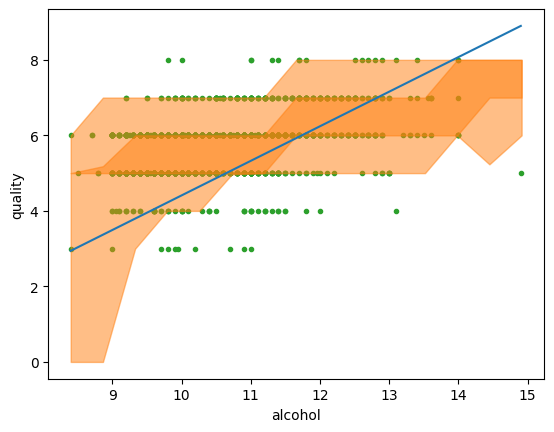

In [ ]:
#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_lineh = idata1.posterior["mu"].mean(("chain", "draw"))

#creates some x values to run through our line formula
alcohol = np.random.normal(wine.alcohol.values, 0.01)
idx = np.argsort(alcohol)
x = np.linspace(alcohol.min(), alcohol.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata1.posterior_predictive["y"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(alcohol[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(wine.alcohol, wine.quality, "C2.", zorder=-3)
ax.plot(wine.alcohol[idx], mean_lineh[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("alcohol")
ax.set_ylabel("quality")

To see how my model did, I also used the posterior predictive distribution from the notes. The model predicts slightly differently from the mean line of the data. We can see where the cutpoints are. I think it is interesting how the model moves up one step at a time.

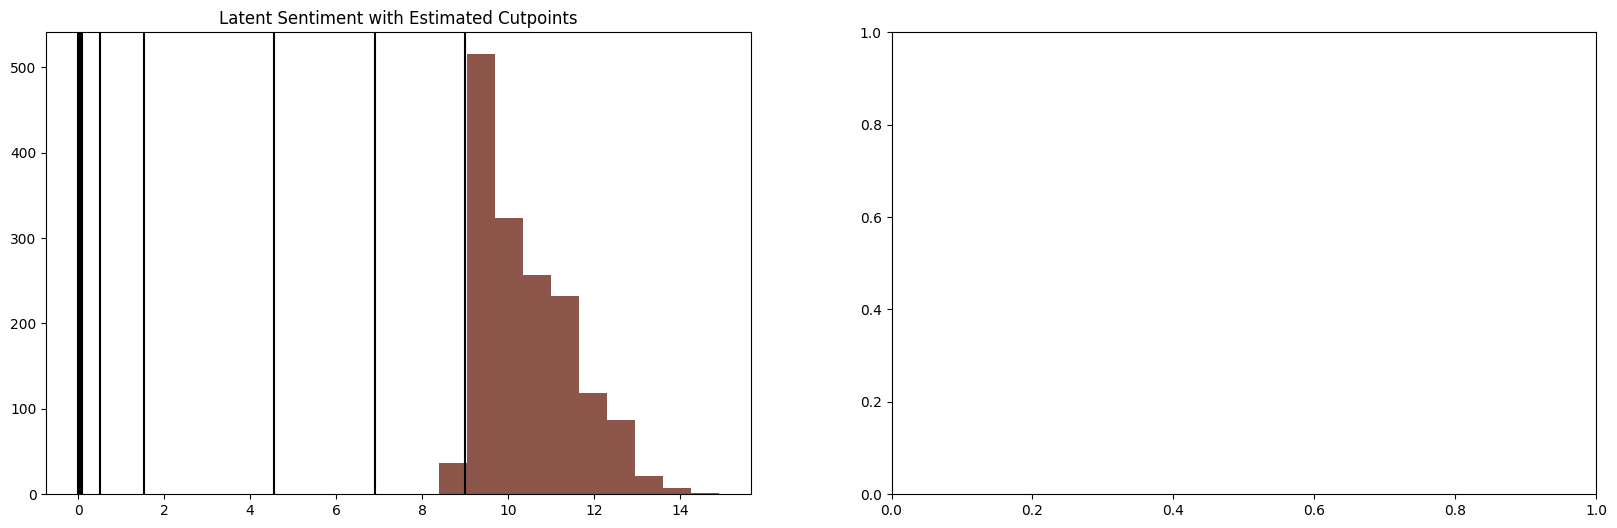

In [ ]:
posterior = idata1.posterior.stack(sample=("chain", "draw"))
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs = axs.flatten()
ax = axs[0]
for i in range(K - 1):
    ax.axvline(posterior["cutpoints"][i].mean().values, color="k")
for r in wine.quality.unique():
    temp = wine[wine.quality == r]
    ax.hist(wine.alcohol, ec="white")
ax.set_title("Latent Sentiment with Estimated Cutpoints")
plt.show()

##Model 2##

Went back and made a model with corrected wine.quality values.

In [ ]:
with pm.Model() as model2:
  cutpoints = constrainedUniform(6, 0, 6)

  #priors
  alpha = pm.Normal('alpha', 0, 5)
  beta = pm.Normal("beta", 0, 4)

  #deterministic to make linear model
  mu = pm.Deterministic("mu", alpha + beta * wine.alcohol)

  #ordered logistic, which is good for ordered categorical outcomes (ratings)
  y_ = pm.OrderedLogistic("y", cutpoints=cutpoints, eta=mu, observed=(wine.quality-3))

  idata2 = pm.sample()

Output()

Output()

Output()

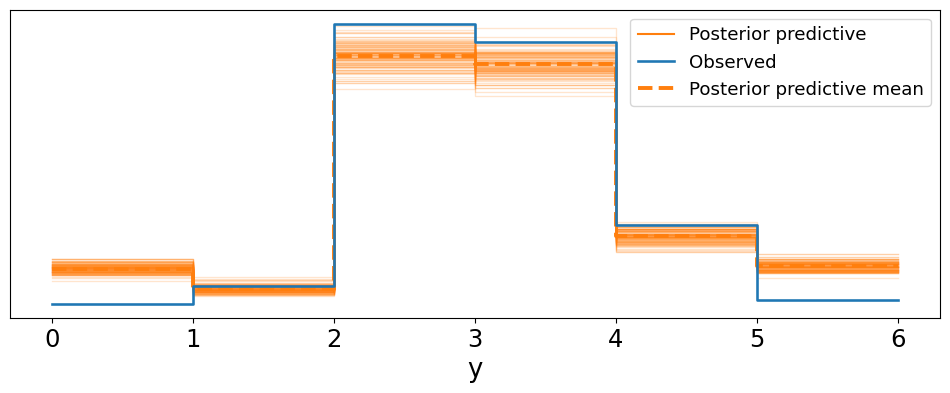

In [ ]:
pm.sample_posterior_predictive(idata2, model=model2, extend_inferencedata=True)
axL = az.plot_ppc(idata2, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

Text(0, 0.5, 'quality')

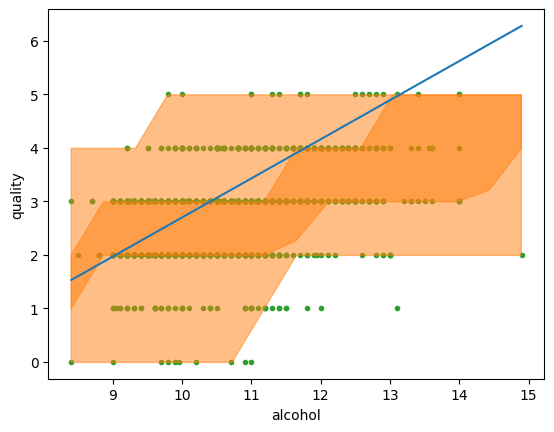

In [ ]:
#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_lineh = idata2.posterior["mu"].mean(("chain", "draw"))

#creates some x values to run through our line formula
alcohol = np.random.normal(wine.alcohol.values, 0.01)
idx = np.argsort(alcohol)
x = np.linspace(alcohol.min(), alcohol.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata2.posterior_predictive["y"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(alcohol[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(wine.alcohol, (wine.quality-3), "C2.", zorder=-3)
ax.plot(wine.alcohol[idx], mean_lineh[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("alcohol")
ax.set_ylabel("quality")

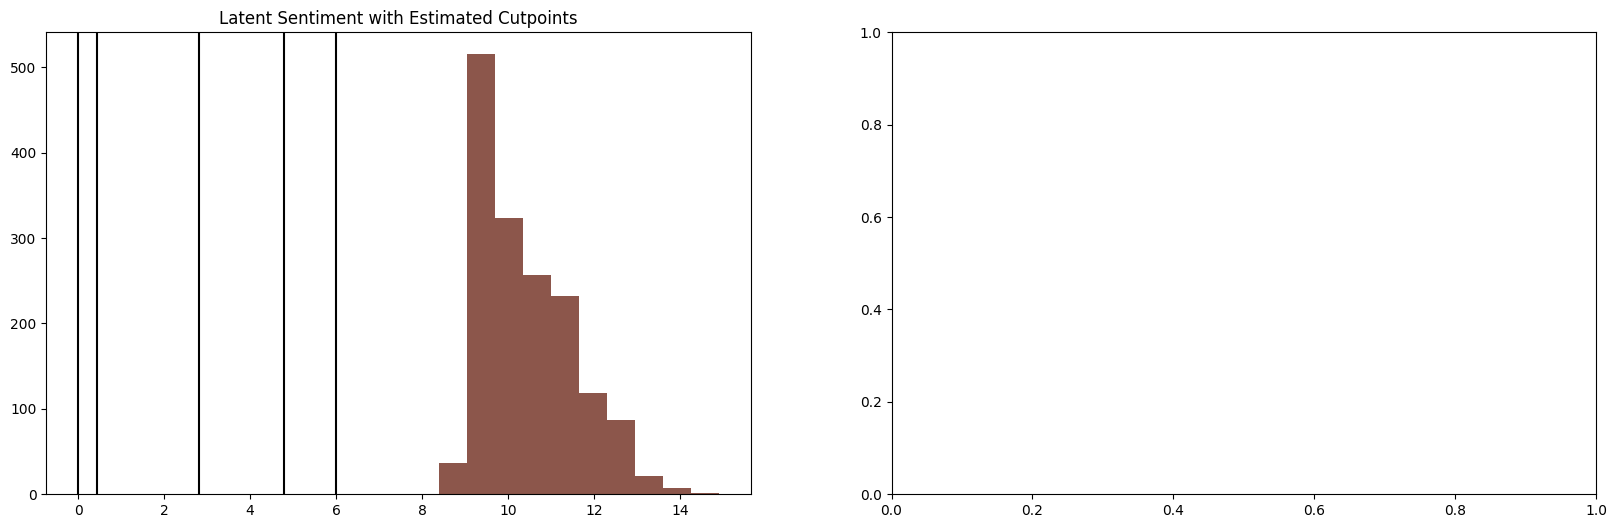

In [ ]:
posterior = idata2.posterior.stack(sample=("chain", "draw"))
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs = axs.flatten()
ax = axs[0]
for i in range(6 - 1):
    ax.axvline(posterior["cutpoints"][i].mean().values, color="k")
for r in wine.quality.unique():
    temp = wine[wine.quality == r]
    ax.hist(wine.alcohol, ec="white")
ax.set_title("Latent Sentiment with Estimated Cutpoints")
plt.show()

#Unit 6 Project!#

I am going to use the same data as my previous project because I think it is interesting and I sort of understand the ordered logistic distribution.

In [25]:
wine['quality_adj'] = wine['quality'].sub(3)
wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_adj
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,2
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,2
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,2
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,3
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,2
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,3
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,3
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,2


###Functions###

In [26]:
def constrainedUniform(N, min=0, max=1):   #I think this function makes a distribution that helps split our prior into parts, based on the number
    return pm.Deterministic(               #of ouput categoris
        "cutpoints",
        pt.concatenate(
            [
                np.ones(1) * min,
                pt.extra_ops.cumsum(pm.Dirichlet("cuts_unknown", a=np.ones(N - 2))) * (max - min)
                + min,
            ]
        ),
    ) #source pymc documentation: https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-ordinal-regression.html

In [27]:
# Function to plot posterior predictive distribution for a given feature
def plot_posterior(feature_name, feature_values, ax, idata):
    mean_line = idata.posterior["mu"].mean(("chain", "draw"))

    # Create synthetic x values
    feature_noise = np.random.normal(feature_values, 0.01)
    idx = np.argsort(feature_noise)
    x = np.linspace(feature_noise.min(), feature_noise.max(), 15)

    # Get 94% and 50% HDIs
    y_pred_q = idata.posterior_predictive["y"].quantile(
        [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
    )
    y_hat_bounds = iter(
        [PchipInterpolator(feature_noise[idx], y_pred_q[i][idx])(x) for i in range(4)]
    )

    # Plot raw data and best-fit line
    ax.plot(feature_values, (wine.quality_adj), "C2.", zorder=-3)
    ax.plot(feature_values[idx], mean_line[idx], c="C0")

    # Plot 94% and 50% HDIs
    for lb, ub in zip(y_hat_bounds, y_hat_bounds):
        ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

    # Labels
    ax.set_xlabel(feature_name)
    ax.set_ylabel("Quality")

##Model with Alcohol, Residual Sugar, and Density##

I sitll don't know much about wine. I did some googling and found there is some correlation between density, residual sugar, and alcohol content of a wine, so I decided to do those first.

In [ ]:
K = 6
with pm.Model() as model_alc_dens_sug:
  cutpoints = constrainedUniform(K, 0, K)

  #priors
  alpha1 = pm.Normal('alpha1', 0, 5)
  beta1 = pm.Normal("beta1", 0, 4)
  alpha2 = pm.Normal('alpha2', 0, 5)
  beta2 = pm.Normal("beta2", 0, 4)
  alpha3 = pm.Normal('alpha3', 0, 5)
  beta3 = pm.Normal("beta3", 0, 4)
  #deterministic to make linear model
  mu = pm.Deterministic("mu", (alpha1 + beta1 * wine.alcohol) + (alpha2 + beta2 * wine.density) + (alpha3 + beta3 * wine['residual sugar']))

  #ordered logistic, which is good for ordered categorical outcomes (ratings)
  y_ = pm.OrderedLogistic("y", cutpoints=cutpoints, eta=mu, observed=wine.quality_adj)

  idata_alc_dens_sug = pm.sample(idata_kwargs={"log_likelihood":True})

Output()

Output()

This model took so much longer to run than the ones with only one prior. I tried to make it have different y intercepts for the different inputs but I don't think that worked and instead just increased the model's complexity.

Output()

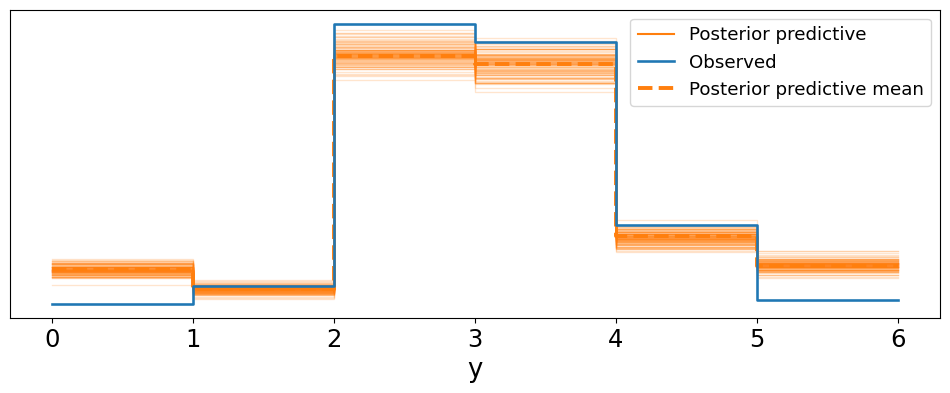

In [42]:
pm.sample_posterior_predictive(idata_alc_dens_sug, model=model_alc_dens_sug, extend_inferencedata=True)
axL = az.plot_ppc(idata_alc_dens_sug, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

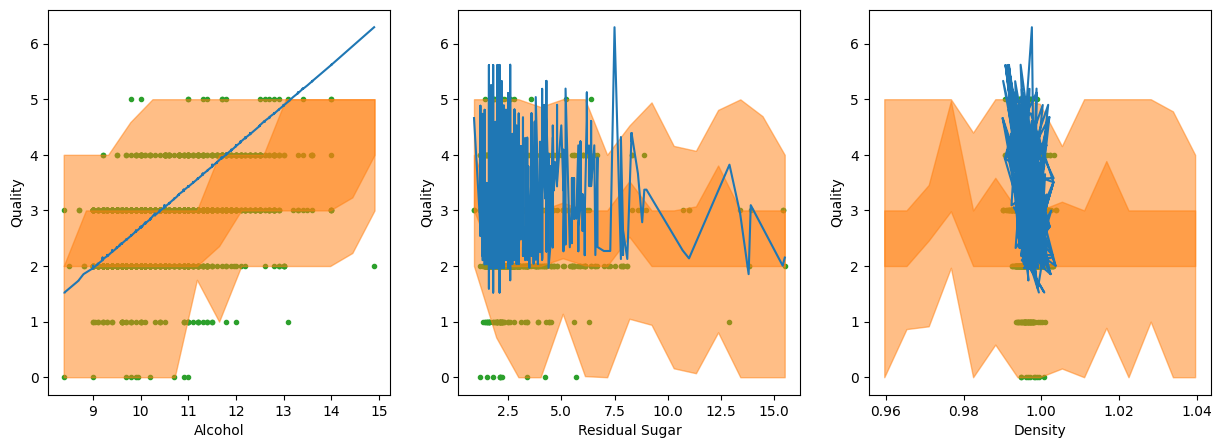

In [43]:
# Create subplots for Alcohol, Residual Sugar, and Density
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
plot_posterior("Alcohol", wine.alcohol.values, axes[0], idata_alc_dens_sug)
plot_posterior("Residual Sugar", wine["residual sugar"].values, axes[1], idata_alc_dens_sug)
plot_posterior("Density", wine.density.values, axes[2], idata_alc_dens_sug)

The posterior predictive check looks pretty good, it is slightly off of the data set (which I assume is very similar to reality because it has a lot of wines). The posterior distributions are weird. The data is very clumped and my model obviously didn't like that.

##Model with Alcohol, Density, and Sulphates##

For this model, I decided to use the three categories that looked like they had the strongest correlations with quality.

In [ ]:
K = 6
with pm.Model() as model_alc_dens_sul:
  cutpoints = constrainedUniform(K, 0, K)

  #priors
  alpha1 = pm.Normal('alpha1', 0, 5)
  beta1 = pm.Normal("beta1", 0, 4)
  alpha2 = pm.Normal('alpha2', 0, 5)
  beta2 = pm.Normal("beta2", 0, 4)
  alpha3 = pm.Normal('alpha3', 0, 5)
  beta3 = pm.Normal("beta3", 0, 4)
  #deterministic to make linear model
  mu = pm.Deterministic("mu", (alpha1 + beta1 * wine.alcohol) + (alpha2 + beta2 * wine.density) + (alpha3 + beta3 * wine.sulphates))

  #ordered logistic, which is good for ordered categorical outcomes (ratings)
  y_ = pm.OrderedLogistic("y", cutpoints=cutpoints, eta=mu, observed=wine.quality_adj)

  idata_alc_dens_sul = pm.sample(idata_kwargs={"log_likelihood":True})

Output()

In [ ]:
pm.sample_posterior_predictive(idata_alc_dens_sul, model=model_alc_dens_sul, extend_inferencedata=True)
axL = az.plot_ppc(idata_alc_dens_sul, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

In [ ]:
# Create subplots for Alcohol, Sulphates, and Density
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
plot_posterior("Alcohol", wine.alcohol.values, axes[0], idata_alc_dens_sul)
plot_posterior("Sulphates", wine.sulphates.values, axes[1], idata_alc_dens_sul)
plot_posterior("Density", wine.density.values, axes[2], idata_alc_dens_sul)

The PPC is very similar to the last one, but the model struggled drawing the mean lines on all of the things, I am not sure where to go from here, so I am going to do a comparison.

##Comparisons##

So oops I forgot to include "idata_kwargs={"log_likelihood":True}" in the parenthesis on my idata things and arviz didn't like that now i need to wait forever for my model to re run :(.

In [ ]:
az.loo(idata_alc_dens_sul)

In [ ]:
#cmp_df stands for compare dataframe
cmp_df = az.compare( {"residual sugar":idata_alc_dens_sug,"sulphates":idata_alc_dens_sul} )

#0 is the best rank; we want a lower elpd_loo
cmp_df